## Import Data
Predict the airline on-time performance based the data from Bureau of Transportation Statics
http://transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time

In [1]:
!ls ./bts_data  #Check all data available

300123874_T_ONTIME1.csv  300123874_T_ONTIME4.csv  300123874_T_ONTIME8.csv
300123874_T_ONTIME10.csv 300123874_T_ONTIME5.csv  300123874_T_ONTIME9.csv
300123874_T_ONTIME2.csv  300123874_T_ONTIME6.csv
300123874_T_ONTIME3.csv  300123874_T_ONTIME7.csv


In [2]:
%matplotlib inline 
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames

# Asemble 2016 on time flight data by combining monthly BTS reports or read only one month data for speed.
one_year = False    

if one_year : 
    import glob
    all_data = pd.DataFrame()
    for f in glob.glob("./bts_data/*.csv"):
        df = pd.read_csv(f)
        all_data = all_data.append(df,ignore_index=True)
    data = all_data[['MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','FL_NUM', 'TAIL_NUM','ORIGIN','DEST','CRS_DEP_TIME','DISTANCE','ARR_DELAY_NEW']]
    print "2016 Jan - Oct data (10 months)"
    print "Data Size:", data.shape
else:   # Or
    data_file = './86361664_T_ONTIME.csv'
    all_data = pd.read_csv(data_file)
    data = all_data[['MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','FL_NUM', 'TAIL_NUM','ORIGIN','DEST','CRS_DEP_TIME','DISTANCE','ARR_DELAY_NEW']]
    print "2016 Jan data (1 month)"
    print "Data Size:", data.shape

2016 Jan data (1 month)
Data Size: (445827, 10)


## Explore Data

In [3]:
# Remove "NAN"
data = data.dropna(axis=0)
print "Data Size after removing NAN:", data.shape

Data Size after removing NAN: (433298, 10)


In [4]:
# Consider only top 10 busniess airports for simplicity and sufficient data.
busy_airports = ['ATL','LAX','ORD','DFW','JFK','DFN','SFO','CLT','LAS','PHX']  # Top 10 busiest aiports
data = data.loc[data['ORIGIN'].isin(busy_airports) & data['DEST'].isin(busy_airports)]  # Select the air traffic between top 10 airports
print "Data Size with top 10 airports only: ", data.shape

Data Size with top 10 airports only:  (32187, 10)


Summary of ARRIVAL_DELAY statistics: 


count    32187.000000
mean        12.965514
std         36.955196
min          0.000000
25%          0.000000
50%          0.000000
75%          9.000000
max       1316.000000
Name: ARR_DELAY_NEW, dtype: float64

On Time Flight percentage : 62.05 %


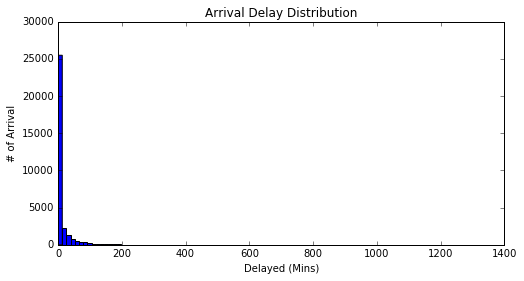

In [5]:
# Show summary of ARRIVAL_DELAY statistics
y = data['ARR_DELAY_NEW']
plt.figure(figsize=(8,4))
plt.hist(y,bins =100)
plt.title('Arrival Delay Distribution')
plt.xlabel('Delayed (Mins)')
plt.ylabel('# of Arrival')
print('Summary of ARRIVAL_DELAY statistics: ')
display(y.describe())


ontime = y[y==0].count()*100./len(y)
print 'On Time Flight percentage : %0.2f' % ontime, '%'

### Remove Outliners

Percentage of outliers to be removed: 1.6 %
Summary of ARRIVAL_DELAY statistics: 


count    31680.000000
mean        11.101010
std         34.105398
min          0.000000
25%          0.000000
50%          0.000000
75%          8.000000
max       1316.000000
Name: ARR_DELAY_NEW, dtype: float64

On Time Flight percentage after outliers are removed : 63.04 %


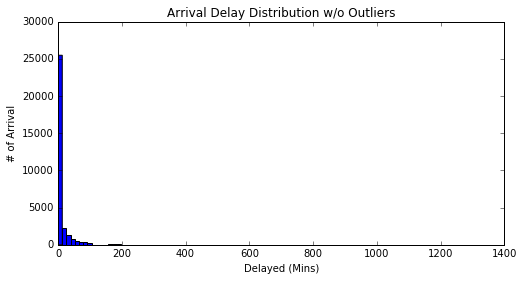

In [7]:
# Detect outliers
y_mean = y.mean()
y_std = y.std()
outliers = y[y-y_mean >4*y_std]  # For classifier problem, 4 sigma is used
print 'Percentage of outliers to be removed: %.1f' % (len(outliers)*100./len(y)),'%'

# Remove outliers
c_data = data.copy()
c_data = data.drop(outliers.index)

# Show summary statistics
y = c_data['ARR_DELAY_NEW']
plt.figure(figsize=(8,4))
plt.hist(y,bins =100)
plt.title('Arrival Delay Distribution w/o Outliers')
plt.xlabel('Delayed (Mins)')
plt.ylabel('# of Arrival')
print('Summary of ARRIVAL_DELAY statistics: ')
display(y.describe())

ontime = y[y==0].count()*100./len(y)
print 'On Time Flight percentage after outliers are removed : %0.2f' % ontime, '%'


### Show delayed arrival (minutes) by mean  for each category

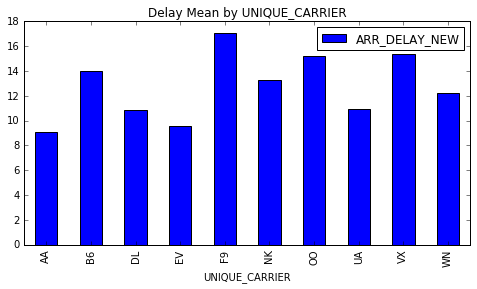

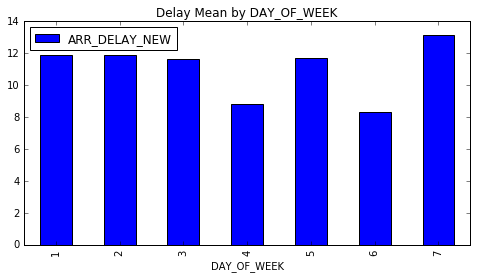

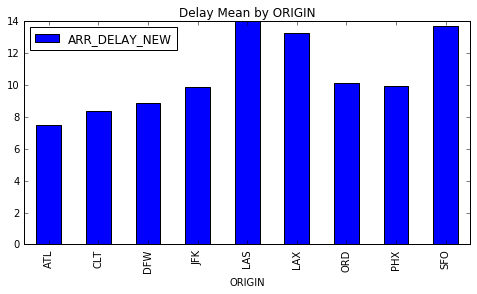

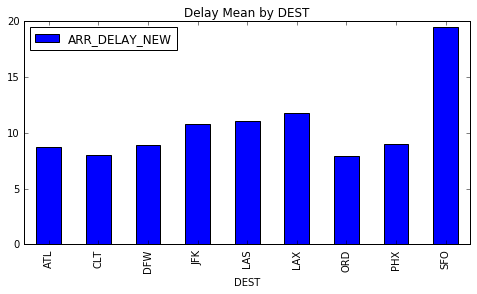

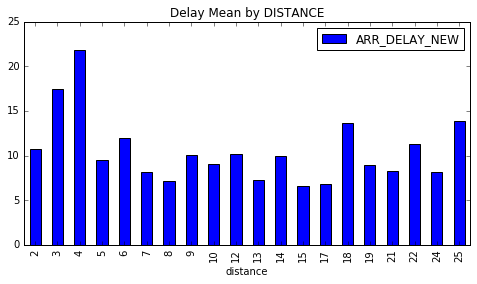

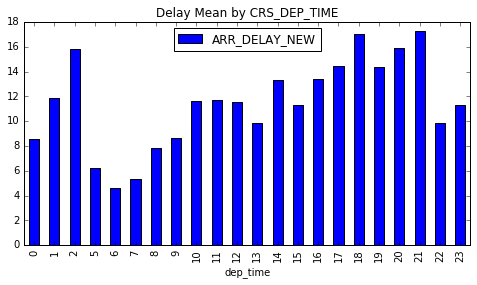

In [8]:
delay_carrier = c_data[['ARR_DELAY_NEW','UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean()
delay_carrier.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by UNIQUE_CARRIER')

delay_day = c_data[['ARR_DELAY_NEW','DAY_OF_WEEK']].groupby('DAY_OF_WEEK').mean()
delay_day.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by DAY_OF_WEEK')

delay_origin = c_data[['ARR_DELAY_NEW','ORIGIN']].groupby('ORIGIN').mean()
delay_origin.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by ORIGIN')

delay_dest = c_data[['ARR_DELAY_NEW','DEST']].groupby('DEST').mean()
delay_dest.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by DEST')

#delay_tail = c_data[['ARR_DELAY_NEW','FL_NUM']].groupby('FL_NUM').mean()
#delay_tail.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by FL_NUM')

# Bucketze the distantce by 100.
c_data.loc[:,'distance'] = [int(i//100) for i in c_data['DISTANCE']]  

delay_distance = c_data[['ARR_DELAY_NEW','distance']].groupby('distance').mean()
delay_distance.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by DISTANCE')

# Bucketize time by hours
c_data.loc[:,'dep_time'] = [i//100 for i in c_data['CRS_DEP_TIME']]   
delay_dep_time = c_data[['ARR_DELAY_NEW','dep_time']].groupby('dep_time').mean()
delay_dep_time.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by CRS_DEP_TIME')


#delay_month = c_data[['ARR_DELAY_NEW','MONTH']].groupby('MONTH').mean()
#delay_month.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by MONTH') 


### Show on-time arrival percentage for each category

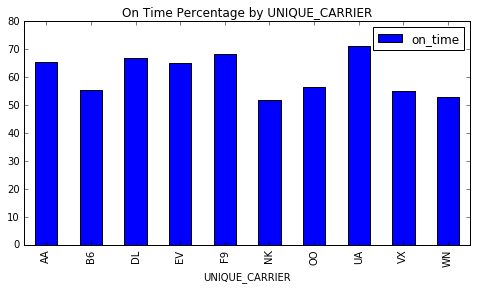

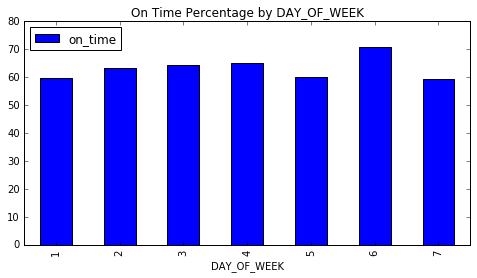

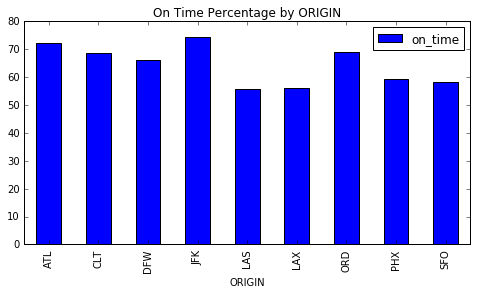

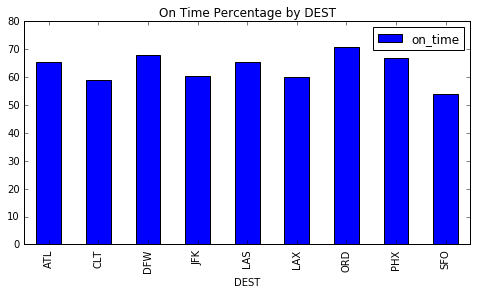

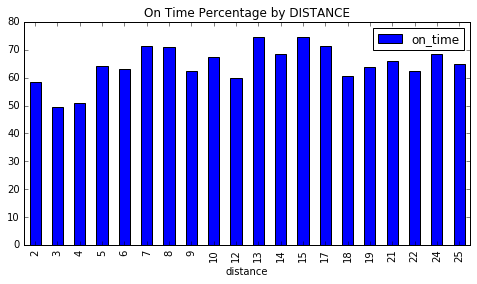

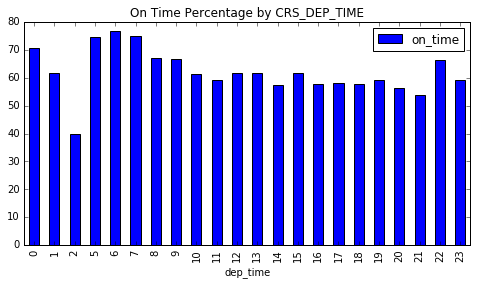

In [9]:
on_time = y ==0

c_data.loc[:,'on_time'] = on_time

delay_carrier = c_data[['on_time','UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean()*100
delay_carrier.plot(kind='bar',figsize =(8,4),title = 'On Time Percentage by UNIQUE_CARRIER')

delay_day = c_data[['on_time','DAY_OF_WEEK']].groupby('DAY_OF_WEEK').mean()*100
delay_day.plot(kind='bar',figsize =(8,4),title = 'On Time Percentage by DAY_OF_WEEK')

delay_origin = c_data[['on_time','ORIGIN']].groupby('ORIGIN').mean()*100
delay_origin.plot(kind='bar',figsize =(8,4),title = 'On Time Percentage by ORIGIN')

delay_dest = c_data[['on_time','DEST']].groupby('DEST').mean()*100
delay_dest.plot(kind='bar',figsize =(8,4),title = 'On Time Percentage by DEST')

#delay_tail = c_data[['on_time','FL_NUM']].groupby('FL_NUM').mean()
#delay_tail.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by FL_NUM')

delay_distance = c_data[['on_time','distance']].groupby('distance').mean()*100
delay_distance.plot(kind='bar',figsize =(8,4),title = 'On Time Percentage by DISTANCE')

# Bucketize time by hours   
delay_dep_time = c_data[['on_time','dep_time']].groupby('dep_time').mean()*100
delay_dep_time.plot(kind='bar',figsize =(8,4),title = 'On Time Percentage by CRS_DEP_TIME')


#delay_month = c_data[['on_time','MONTH']].groupby('MONTH').mean()
#delay_month.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by MONTH') 



## Preprocess the data

#### Encode categorical data into binary numbers using 'pd.get_dummies'

In [10]:
# Convert numerical categorical data to strings
c_data.loc[:,'distance_c'] = [str(i) for i in c_data['distance']] 
c_data.loc[:,'dep_time_c'] = [str(i) for i in c_data['dep_time']] 
c_data.loc[:,'day_c'] = [str(i) for i in c_data['DAY_OF_WEEK']] 

cat_cols = ['day_c','dep_time_c','distance_c','UNIQUE_CARRIER','ORIGIN','DEST']
r_data = pd.get_dummies(c_data[cat_cols])
y = c_data['on_time']
X = r_data
display(r_data.columns)
display( r_data.head())

Index([u'day_c_1', u'day_c_2', u'day_c_3', u'day_c_4', u'day_c_5', u'day_c_6',
       u'day_c_7', u'dep_time_c_0', u'dep_time_c_1', u'dep_time_c_10',
       u'dep_time_c_11', u'dep_time_c_12', u'dep_time_c_13', u'dep_time_c_14',
       u'dep_time_c_15', u'dep_time_c_16', u'dep_time_c_17', u'dep_time_c_18',
       u'dep_time_c_19', u'dep_time_c_2', u'dep_time_c_20', u'dep_time_c_21',
       u'dep_time_c_22', u'dep_time_c_23', u'dep_time_c_5', u'dep_time_c_6',
       u'dep_time_c_7', u'dep_time_c_8', u'dep_time_c_9', u'distance_c_10',
       u'distance_c_12', u'distance_c_13', u'distance_c_14', u'distance_c_15',
       u'distance_c_17', u'distance_c_18', u'distance_c_19', u'distance_c_2',
       u'distance_c_21', u'distance_c_22', u'distance_c_24', u'distance_c_25',
       u'distance_c_3', u'distance_c_4', u'distance_c_5', u'distance_c_6',
       u'distance_c_7', u'distance_c_8', u'distance_c_9', u'UNIQUE_CARRIER_AA',
       u'UNIQUE_CARRIER_B6', u'UNIQUE_CARRIER_DL', u'UNIQUE_CARRIER_EV

,day_c_1,day_c_2,day_c_3,day_c_4,day_c_5,day_c_6,day_c_7,dep_time_c_0,dep_time_c_1,dep_time_c_10,...,ORIGIN_SFO,DEST_ATL,DEST_CLT,DEST_DFW,DEST_JFK,DEST_LAS,DEST_LAX,DEST_ORD,DEST_PHX,DEST_SFO
153,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
154,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
156,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
157,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Scale Data  
#### Not neccessary for this applicaton since all features are OneHotEncoded - all feature values are 0 or 1.



## Randomly split the data into test and train set

In [11]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.3,random_state =0)

print 'Blanced data set(# of True/ of Total): %.3f' % (float(y_train.sum())/len(y_train))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Blanced data set(# of True/ of Total): 0.629


((22176, 77), (9504, 77), (22176,), (9504,))

### Reduce the dimensionality of the features.
Applied PCA to identify the dominant features (= princial axes)

[  6.75377452e-02   4.48706438e-02   4.12287412e-02   3.76263846e-02
   3.63387995e-02   3.08979340e-02   2.94865384e-02   2.89073879e-02
   2.82844670e-02   2.65183600e-02   2.60605783e-02   2.57377810e-02
   2.54547039e-02   2.51190425e-02   2.45171495e-02   2.36897230e-02
   2.26868052e-02   2.16527383e-02   2.07120914e-02   2.03922852e-02
   1.63176230e-02   1.56802772e-02   1.46661442e-02   1.43828658e-02
   1.39546847e-02   1.36114739e-02   1.31611058e-02   1.29105343e-02
   1.25232896e-02   1.23004517e-02   1.22083963e-02   1.20642515e-02
   1.16538417e-02   1.15309200e-02   1.13511668e-02   1.12009172e-02
   1.04210751e-02   1.01507913e-02   1.00593429e-02   9.89571094e-03
   9.76371061e-03   9.39019000e-03   9.21853131e-03   8.69442188e-03
   8.29410191e-03   8.01672389e-03   7.37128924e-03   6.81228506e-03
   6.67348267e-03   6.48155216e-03   6.20823335e-03   6.00276359e-03
   5.69258560e-03   5.53355003e-03   5.28232049e-03   5.00096549e-03
   4.33347504e-03   3.33925660e-03

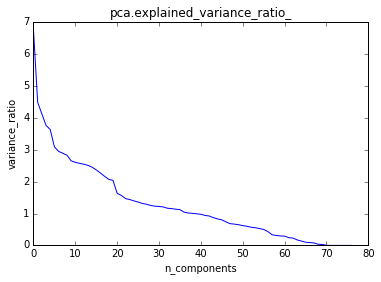

In [12]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_*100)
plt.title('pca.explained_variance_ratio_')
plt.xlabel('n_components')
plt.ylabel('variance_ratio')
print pca.explained_variance_ratio_

### ==> Select first 20 features by inspecting pca.explained_variance 

#Not Applied no impact on the overall performance  in this application
#Apply PCA to X_train and X_test
pca60 = PCA(n_components = 20)
pca60.fit(X_train)
X_train_pca = pca60.transform(X_train)
X_test_pca = pca60.transform(X_test)   # pca60 is fitted by X_train, not X_test
X_train = X_train_pca
X_test = X_test_pca
print X_train

## Try out a few classifier algorithms on training set

In [13]:
# Display classifier performance score
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score,roc_auc_score

def display_scores(y_test,y_pred):
    print '# of Data:',len(y_test) 
    print 'Accuracy: %.3f' %  accuracy_score(y_test,y_pred)
    print 'Precision: %.3f' %  precision_score(y_test,y_pred)
    print 'Recall: %.3f' %  recall_score(y_test,y_pred)
    print 'F1 Score: %.3f' %  f1_score(y_test,y_pred)
    print 'ROC AUC: %.3f' %  roc_auc_score(y_test,y_pred)
    print

# K-fold cross-validate
from sklearn.cross_validation import cross_val_score

def cross_validate(estimator,X_train,y_train):
    scores = cross_val_score(estimator=estimator,X=X_train,y=y_train,cv=5,n_jobs=-1)
    print ('CV accuracy_scores: %s' % scores)
    print ('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
    print

from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_test,y_pred): 
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr , color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    Plt.ylabel('True Postive Rate')
    plt.show()

from sklearn.metrics import confusion_matrix
def show_confusion_matrix(y_test,y_pred):
    confmat = confusion_matrix(y_test,y_pred)
    fig,ax = plt.subplots(figsize =(4,4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j,y=i, s=confmat[i,j], va='center',ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

### Decison Tree Classifier

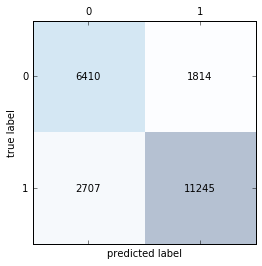

# of Data: 22176
Accuracy: 0.796
Precision: 0.861
Recall: 0.806
F1 Score: 0.833
ROC AUC: 0.793

CV accuracy_scores: [ 0.58228133  0.58025248  0.57790304  0.58624577  0.5834461 ]
CV accuracy: 0.582 +/- 0.003



In [14]:
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state =0)
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_train)

show_confusion_matrix(y_train,y_pred)
display_scores(y_train,y_pred)
cross_validate(dtc,X_train,y_train)

### Random Forest Classifier

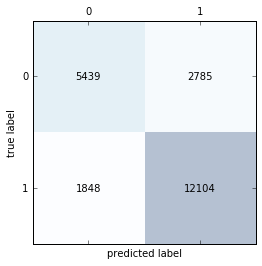

# of Data: 22176
Accuracy: 0.791
Precision: 0.813
Recall: 0.868
F1 Score: 0.839
ROC AUC: 0.764

CV accuracy_scores: [ 0.6138413   0.60640216  0.60157835  0.6065389   0.60960758]
CV accuracy: 0.608 +/- 0.004



In [15]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_train)

show_confusion_matrix(y_train,y_pred)
display_scores(y_train,y_pred)
cross_validate(rfc,X_train,y_train)

### Logistic Regression Classifier

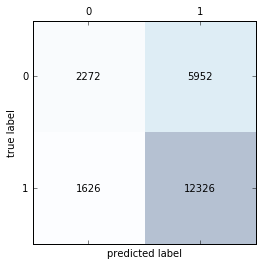

# of Data: 22176
Accuracy: 0.658
Precision: 0.674
Recall: 0.883
F1 Score: 0.765
ROC AUC: 0.580

CV accuracy_scores: [ 0.65554554  0.65915239  0.64847802  0.64735062  0.66599008]
CV accuracy: 0.655 +/- 0.007



In [17]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(random_state =0)
lgr.fit(X_train,y_train)
y_pred = lgr.predict(X_train)

show_confusion_matrix(y_train,y_pred)
display_scores(y_train,y_pred)
cross_validate(lgr,X_train,y_train)

### Support Vector Machine Classifier

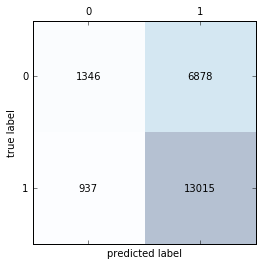

# of Data: 22176
Accuracy: 0.648
Precision: 0.654
Recall: 0.933
F1 Score: 0.769
ROC AUC: 0.548

CV accuracy_scores: [ 0.62669071  0.62917042  0.6421646   0.63201804  0.6330627 ]
CV accuracy: 0.633 +/- 0.005



In [18]:
from sklearn.svm import SVC

svc = SVC(random_state = 0)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_train)

show_confusion_matrix(y_train,y_pred)
display_scores(y_train,y_pred)
cross_validate(svc,X_train,y_train)

### GaussianNB 

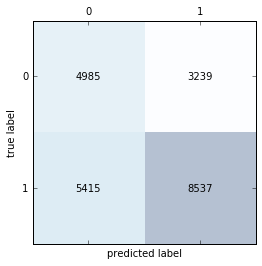

# of Data: 22176
Accuracy: 0.610
Precision: 0.725
Recall: 0.612
F1 Score: 0.664
ROC AUC: 0.609

CV accuracy_scores: [ 0.44792606  0.61767358  0.60315671  0.60992108  0.60915652]
CV accuracy: 0.578 +/- 0.065



In [19]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_train)

show_confusion_matrix(y_train,y_pred)
display_scores(y_train,y_pred)
cross_validate(gnb,X_train,y_train)


## Summary of Classfiers Cross Validation without fine tunning: 

In [20]:
print('Decision Tree:')
cross_validate(dtc,X_train,y_train)
print('Random Forest:')
cross_validate(rfc,X_train,y_train)
print('Logistic Regression:')
cross_validate(lgr,X_train,y_train)
print('Support Vector Machine:')
cross_validate(svc,X_train,y_train)
print('Gaussian NB:')
cross_validate(gnb,X_train,y_train)


Decision Tree:
CV accuracy_scores: [ 0.58228133  0.58025248  0.57790304  0.58624577  0.5834461 ]
CV accuracy: 0.582 +/- 0.003

Random Forest:
CV accuracy_scores: [ 0.6138413   0.60640216  0.60157835  0.6065389   0.60960758]
CV accuracy: 0.608 +/- 0.004

Logistic Regression:
CV accuracy_scores: [ 0.65554554  0.65915239  0.64847802  0.64735062  0.66599008]
CV accuracy: 0.655 +/- 0.007

Support Vector Machine:
CV accuracy_scores: [ 0.62669071  0.62917042  0.6421646   0.63201804  0.6330627 ]
CV accuracy: 0.633 +/- 0.005

Gaussian NB:
CV accuracy_scores: [ 0.44792606  0.61767358  0.60315671  0.60992108  0.60915652]
CV accuracy: 0.578 +/- 0.065



###  => Logistics Regression (parametric) and RamdomForest (non-parametric) are selected based on the cross validation score and computation speed.

## Fine tuning the selected classifiers with GridSearchCV

In [21]:
from sklearn.grid_search import GridSearchCV

rfc = RandomForestClassifier(random_state = 0)
parameters = {'max_features':('auto','log2',None), 'n_estimators':[10,20,50,100,200,400,500]}
rfc_gs = GridSearchCV(rfc,parameters,scoring='accuracy',n_jobs =-1,cv=5)
rfc_gs.fit(X_train,y_train)
print(rfc_gs.best_score_)
print(rfc_gs.best_params_)


0.626037157287
{'max_features': 'auto', 'n_estimators': 500}


In [22]:
from sklearn.grid_search import GridSearchCV

lgr = LogisticRegression(random_state =0)
parameters = {'penalty':('l1','l2'), 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000] }
lgr_gs = GridSearchCV(lgr,parameters,scoring='accuracy',n_jobs =-1,cv=5)
lgr_gs.fit(X_train,y_train)
print(lgr_gs.best_score_)
print(lgr_gs.best_params_)

0.655393217893
{'penalty': 'l1', 'C': 0.1}


## Demonstrate the classifier performance on the test data (= unseen data)

### Test accuracy-optimal Random Forest Classifier

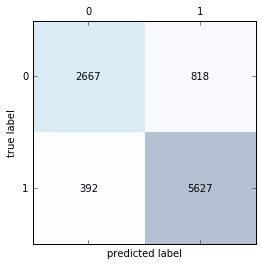

# of Data: 9504
Accuracy: 0.873
Precision: 0.873
Recall: 0.935
F1 Score: 0.903
ROC AUC: 0.850



In [25]:
rfc_opt = RandomForestClassifier(max_features = rfc_gs.best_params_['max_features'],n_estimators = rfc_gs.best_params_['n_estimators'],random_state =0)
rfc_opt.fit(X_test,y_test)
y_pred = rfc_opt.predict(X_test)

show_confusion_matrix(y_test,y_pred)
display_scores(y_test,y_pred)

#### => Random Forest achieved accuracy of 0.873  with unseen test data set

### Test accuracy-optimal Logistic Regressio Classifier

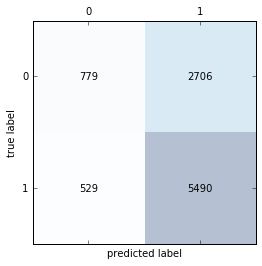

# of Data: 9504
Accuracy: 0.660
Precision: 0.670
Recall: 0.912
F1 Score: 0.772
ROC AUC: 0.568



In [24]:
lgr_opt = LogisticRegression(penalty = lgr_gs.best_params_['penalty'],C = lgr_gs.best_params_['C'],random_state =0)
lgr_opt.fit(X_test,y_test)
y_pred = lgr_opt.predict(X_test)

show_confusion_matrix(y_test,y_pred)
display_scores(y_test,y_pred)

#### => Logistic regression achieved  accuray of 0.660 only with unseen test data set